[![gammapy](https://img.shields.io/badge/powered%20by-gammapy-orange.svg?style=flat)](https://gammapy.org/)

# 1D spectrum simulation
**Tutors:** Rubens Costa Jr and M Felipe Sousa.

This hands-on tutorial gives an introduction of how to simulate a number of spectral on-off observations of a source with a exponential cutoff power law spectral model using the CTA 1DC response and fit them with the assumed spectral model.


## Preface
We recommend to follow this tutorial by **executing the code cells on your local machine**, along with the tutor. The estimated time for this part of the tutorial is ~60 minutes.

We're happy to receive any **feedback or questions** on the tutorial via mail to *rubensjrcosta@gmail.com* or *manoelfelipesousa@gmail.com*.

<a id='intro'></a>
## Indice
* [**1. 1D spectrum simulation**](#simu)

* [**2. Setup**](#setup)

* [**3. Source Information**](#step3)
    
* [**4. Observational parameters**](#step4)

* [**5. Creates the Observation**](#step5)

* [**6. Simulating the Spectrum**](#step6)
    * Defines the geometry
    * Set the Model on the Dataset
    
* [**7. On-Off analysis**](#step7)

* [**8. Computing the Flux Points**](#step8)

In [1]:
%matplotlib inline

<a id='simu'></a>
🔝 [Back to Top](#intro)<br>
## 1.  1D spectrum simulation

Simulate a number of spectral on-off observations of a source with a exponential cutoff power law spectral model using the CTA 1DC response and fit them with the assumed spectral model.

## Prerequisites

-  Knowledge of spectral extraction and datasets used in gammapy, see
   for instance the :doc:`spectral analysis
   tutorial </tutorials/analysis-1d/spectral_analysis>`

## Context

To simulate a specific observation, it is not always necessary to
simulate the full photon list. For many uses cases, simulating directly
a reduced binned dataset is enough: the IRFs reduced in the correct
geometry are combined with a source model to predict an actual number of
counts per bin. The latter is then used to simulate a reduced dataset
using Poisson probability distribution.

This can be done to check the feasibility of a measurement, to test
whether fitted parameters really provide a good fit to the data etc.

Here we will see how to perform a 1D spectral simulation of a CTA
observation, in particular, we will generate OFF observations following
the template background stored in the CTA IRFs.

**Objective: simulate a number of spectral ON-OFF observations of a
source with a power-law spectral model with CTA using the CTA 1DC
response, fit them with the assumed spectral model and check that the
distribution of fitted parameters is consistent with the input values.**

## Proposed approach

We will use the following classes and functions:

-  `~gammapy.datasets.SpectrumDatasetOnOff`
-  `~gammapy.datasets.SpectrumDataset`
-  `~gammapy.irf.load_irf_dict_from_file`
-  `~gammapy.modeling.models.ExpCutoffPowerLawSpectralModel`

<a id='setup'></a>
🔝 [Back to Top](#intro)<br>
## 2. Setup

In [ ]:
!pip install gammapy

In [ ]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()

**Important**: to run this tutorial the environment variable `GAMMAPY_DATA` must be defined and point to the directory on your machine where the datasets needed are placed. To check whether your setup is correct you can execute the following cell:

In [ ]:
import os # Miscellaneous operating system interfaces
os.environ['GAMMAPY_DATA'] = os.path.join(os.getcwd(), '/content/gammapy-data/1.2')

In [ ]:
try:
    from gammapy.data import DataStore
    DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
    print("Check setup: OK")
except: print("Error")

Tell us about any errors you come across!

Now we can continue with the usual IPython notebooks and Python imports:

In [2]:
# Display figures directly inline
%matplotlib inline

import matplotlib.pyplot as plt # A collection of command style functions
from IPython.display import display

In [3]:
import numpy as np

import corner

import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.table import Table

from regions import CircleSkyRegion

from gammapy.datasets import (
    Datasets, 
    SpectrumDataset, 
    SpectrumDatasetOnOff
)

from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom
from gammapy.modeling import Fit

from gammapy.modeling.models import (
    PowerLawSpectralModel, 
    SkyModel, 
    ExpCutoffPowerLawSpectralModel
)

from gammapy.data import (
    Observation, 
    observatory_locations, 
    FixedPointingInfo, 
    PointingMode
)

from gammapy.estimators import FluxPointsEstimator, FluxPoints

from gammapy.datasets import FluxPointsDataset

<a id='step3'></a>
🔝 [Back to Top](#intro)<br>
## Step 3: Source Information

In [4]:
source_pos = SkyCoord(0, 0, unit="deg", frame="galactic").icrs # Target position
print(source_pos)

<SkyCoord (ICRS): (ra, dec) in deg
    (266.40498829, -28.93617776)>


In [5]:
model_simu = ExpCutoffPowerLawSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=2,
    lambda_=0.1 * u.Unit("TeV-1"),
    reference=1 * u.TeV,
)

print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu, name="source")

ExpCutoffPowerLawSpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral     index 2.0000e+00                ... nan  False   False     
spectral amplitude 1.0000e-12 TeV-1 s-1 cm-2 ... nan  False    True     
spectral reference 1.0000e+00            TeV ... nan   True   False     
spectral   lambda_ 1.0000e-01          TeV-1 ... nan  False   False     
spectral     alpha 1.0000e+00                ... nan   True   False     


<a id='step4'></a>
🔝 [Back to Top](#intro)<br>
## Step 4: Observational parameters

To do a simulation, we need to define the observational parameters like
the livetime, the offset, the assumed integration radius, the energy
range to perform the simulation for and the choice of spectral model. We
then use an in-memory observation which is convolved with the IRFs to
get the predicted number of counts. This is Poisson fluctuated using
the `fake()` to get the simulated counts for each observation.




In [6]:
livetime = 1 * u.h # Time of the simulated observation

In [7]:
offset = 1.0 * u.deg  # Pointing position offset

In [8]:
e_edges_min = 0.1 * u.TeV  # Minimum energy
e_edges_max = 100. * u.TeV # Maximum energy

<a id='step5'></a>
🔝 [Back to Top](#intro)<br>
## Step 5:  Creates the Observation

In this simulation, we use the CTA-1DC IRFs shipped with Gammapy.

In [9]:
# Load the IRFs
irfs = load_irf_dict_from_file(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [10]:
irfs

{'aeff': <gammapy.irf.effective_area.EffectiveAreaTable2D at 0x7f58020244c0>,
 'psf': <gammapy.irf.psf.parametric.EnergyDependentMultiGaussPSF at 0x7f5802045400>,
 'edisp': <gammapy.irf.edisp.core.EnergyDispersion2D at 0x7f5802050a60>,
 'bkg': <gammapy.irf.background.Background3D at 0x7f582dbed880>}

See: [CTAO Instrument Response Functions](https://zenodo.org/records/5499840).  This data repository provides access to performance evaluation and instrument response functions (IRFs) for CTA.

In [11]:
position_angle = 90*u.deg

In [12]:
# Defines the pointing position
pointing_position = source_pos.directional_offset_by(
    position_angle, 
    separation=offset
)
print(pointing_position)

<SkyCoord (ICRS): (ra, dec) in deg
    (267.54760208, -28.93135344)>


In [13]:
# We want to simulate an observation pointing at a fixed position in the sky.
# For this, we use the `FixedPointingInfo` class
pointing = FixedPointingInfo(
    mode=PointingMode.POINTING,
    fixed_icrs=pointing_position,
)
print(pointing)

FixedPointingInfo:

mode:        PointingMode.POINTING
coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (267.54760208, -28.93135344)>


In [14]:
location = observatory_locations["cta_south"]

In [15]:
location

<EarthLocation (1953830.40071076, -5461745.48215685, -2648150.15076259) m>

In [16]:
obs = Observation.create(
    pointing=pointing,
    livetime=livetime,
    irfs=irfs,
    location=location,
)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.04
	duration          : 3600.00 s
	pointing (icrs)   : 267.5 deg, -28.9 deg

	deadtime fraction : 0.0%



<a id='step6'></a>
🔝 [Back to Top](#intro)<br>
## Step 6: Simulating the Spectrum
### Defines the geometry

In [17]:
# Reconstructed energy axis
energy_axis = MapAxis.from_energy_bounds(
    e_edges_min, 
    e_edges_max, 
    nbin=5, 
    per_decade=True, 
    name="energy"
)
print(energy_axis)

MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 15        
	node type  : edges     
	edges min  : 1.0e-01 TeV
	edges max  : 1.0e+02 TeV
	interp     : log       



In [18]:
on_region_radius = Angle("0.11 deg") # radius of the ON region
center = source_pos # observation center

In [19]:
on_region = CircleSkyRegion(
    center=center, 
    radius=on_region_radius
)
print(on_region)

Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (266.40498829, -28.93617776)>
radius: 0.11 deg


In [20]:
geom = RegionGeom.create(
    region=on_region, 
    axes=[energy_axis]
)
print(geom)

RegionGeom

	region     : CircleSkyRegion
	axes       : ['lon', 'lat', 'energy']
	shape      : (1, 1, 15)
	ndim       : 3
	frame      : icrs
	center     : 266.4 deg, -28.9 deg



🔝 [Back to Top](#intro)<br>

### Set the Model on the Dataset

In [21]:
# Defines the true energy axis:
# true energy axis should be wider than reco energy axis
energy_axis_true = MapAxis.from_energy_bounds(
    0.3*e_edges_min, 
    3*e_edges_max, 
    nbin=8, 
    per_decade=True, 
    name="energy_true"
)
print(energy_axis_true)

MapAxis

	name       : energy_true
	unit       : 'TeV'     
	nbins      : 32        
	node type  : edges     
	edges min  : 3.0e-02 TeV
	edges max  : 3.0e+02 TeV
	interp     : log       



In [22]:
# Creates a SpectrumDataset object with zero filled maps.
dataset_empty = SpectrumDataset.create(
    geom=geom, 
    energy_axis_true=energy_axis_true, 
    name="obs-0"
)
print(dataset_empty)

SpectrumDataset
---------------

  Name                            : obs-0 

  Total counts                    : 0 
  Total background counts         : 0.00
  Total excess counts             : 0.00

  Predicted counts                : 0.00
  Predicted background counts     : 0.00
  Predicted excess counts         : nan

  Exposure min                    : 0.00e+00 m2 s
  Exposure max                    : 0.00e+00 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 0 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [23]:
# Make spectrum for a single IACT observation:
maker = SpectrumDatasetMaker(
    selection=
    ["exposure", 
     "edisp", 
     "background"]
) # Selecting which maps to make

dataset = maker.run(dataset_empty, obs) 
print(dataset)

SpectrumDataset
---------------

  Name                            : obs-0 

  Total counts                    : 0 
  Total background counts         : 112.93
  Total excess counts             : -112.93

  Predicted counts                : 112.93
  Predicted background counts     : 112.93
  Predicted excess counts         : nan

  Exposure min                    : 7.30e+07 m2 s
  Exposure max                    : 1.88e+10 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [24]:
# Set the model on the dataset, and fake
dataset.models = model
dataset.fake(random_state=42)
print(dataset) # Make safe data range mask for a given observation

SpectrumDataset
---------------

  Name                            : obs-0 

  Total counts                    : 242 
  Total background counts         : 112.93
  Total excess counts             : 129.07

  Predicted counts                : 250.82
  Predicted background counts     : 112.93
  Predicted excess counts         : 137.89

  Exposure min                    : 7.30e+07 m2 s
  Exposure max                    : 1.88e+10 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -1196.19

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index                     

You can see that background counts are now simulated.

<a id='step7'></a>
🔝 [Back to Top](#intro)<br>
## Step 7: On-Off analysis

To do an on off spectral analysis, which is the usual science case, the
standard would be to use `SpectrumDatasetOnOff`, which uses the
acceptance to fake off-counts. Please also refer to the `Dataset simulations`
section in the :doc:`/tutorials/analysis-1d/spectral_analysis_rad_max` tutorial,
dealing with simulations based on observations of real off counts.




In [25]:
dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, 
    acceptance=1, 
    acceptance_off=5
)
dataset_on_off.fake(npred_background=dataset.npred_background())

In [26]:
print(dataset_on_off)

SpectrumDatasetOnOff
--------------------

  Name                            : r2rMnK4b 

  Total counts                    : 244 
  Total background counts         : 106.20
  Total excess counts             : 137.80

  Predicted counts                : 244.40
  Predicted background counts     : 106.51
  Predicted excess counts         : 137.89

  Exposure min                    : 7.30e+07 m2 s
  Exposure max                    : 1.88e+10 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15.53

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index          

You can see that off counts are now simulated as well. We now simulate
several spectra using the same set of observation conditions.




In [27]:
n_obs = 20
datasets = Datasets()

for idx in range(n_obs):
    dataset_on_off.fake(random_state=idx, npred_background=dataset.npred_background())
    dataset_fake = dataset_on_off.copy(name=f"obs-{idx}")
    dataset_fake.meta_table["OBS_ID"] = [idx]
    datasets.append(dataset_fake)

table = datasets.info_table()
display(table)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
obs-0,251,138.60000610351562,9.96942249923895,112.39998626708984,135.50000164119731,135.50000164119731,nan,72986008.0,18824503296.0,3600.000000000002,3600.000000000002,0.06972222222222219,0.03122221840752494,0.03850000169542099,15,15,wstat,173.90284235333723,562,15.0,75.00000762939453,0.19999997317790985
obs-1,231,117.6,8.617692924800172,113.4,133.0,133.0,nan,72986008.18278918,18824503367.050323,3600.000000000002,3600.000000000002,0.06416666666666664,0.031499999999999986,0.03266666666666665,15,15,wstat,126.92091878415825,567,15.0,75.0,0.2
obs-2,225,111.80000000000001,8.24960944244913,113.19999999999999,131.83333333333334,131.83333333333334,nan,72986008.18278918,18824503367.050323,3600.000000000002,3600.000000000002,0.062499999999999965,0.03144444444444443,0.031055555555555545,15,15,wstat,128.49550973534215,566,15.0,75.0,0.19999999999999998
obs-3,239,119.0,8.524229764290844,120.0,139.83333333333334,139.83333333333334,nan,72986008.18278918,18824503367.050323,3600.000000000002,3600.000000000002,0.06638888888888886,0.03333333333333332,0.03305555555555554,15,15,wstat,156.37458158663995,600,15.0,75.0,0.2
obs-4,292,172.8,11.785249502664652,119.2,148.00000000000006,148.00000000000006,nan,72986008.18278918,18824503367.050323,3600.000000000002,3600.000000000002,0.08111111111111106,0.0331111111111111,0.04799999999999998,15,15,wstat,214.0806932520341,596,15.0,75.0,0.2
obs-5,243,133.79999999999998,9.77285888294649,109.20000000000002,131.50000000000003,131.50000000000003,nan,72986008.18278918,18824503367.050323,3600.000000000002,3600.000000000002,0.06749999999999996,0.030333333333333323,0.037166666666666646,15,15,wstat,166.22504516267963,546,15.0,74.99999999999999,0.20000000000000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
obs-14,255,145.0,10.442676343530703,110.0,134.16666666666666,134.16666666666666,nan,72986008.18278918,18824503367.050323,3600.000000000002,3600.000000000002,0.0708333333333333,0.03055555555555554,0.04027777777777776,15,15,wstat,221.53856682224688,550,15.0,75.0,0.2


Before moving on to the fit let’s have a look at the simulated
observations.




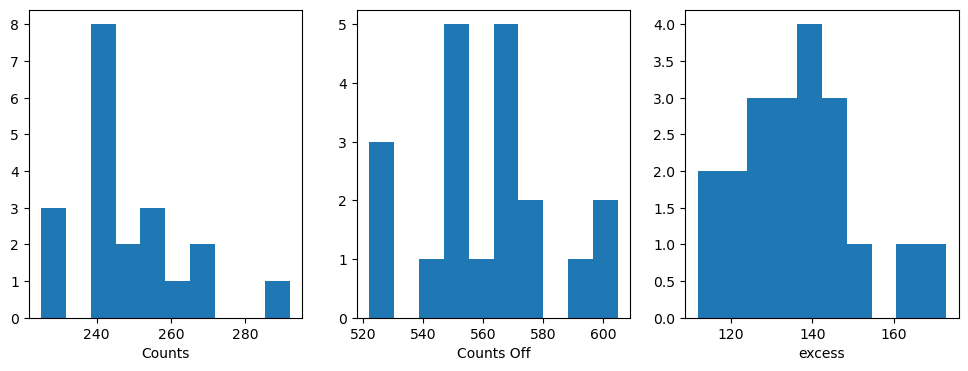

In [28]:
fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(table["counts"])
axes[0].set_xlabel("Counts")
axes[1].hist(table["counts_off"])
axes[1].set_xlabel("Counts Off")
axes[2].hist(table["excess"])
axes[2].set_xlabel("excess")
plt.show()

Now, we fit each simulated spectrum individually




In [29]:
%%time

results = []

fit = Fit()

for dataset in datasets:
    dataset.models = model.copy()
    result = fit.optimize(dataset)
    
    if result.success:
        par_dict = {}
        for par in result.parameters.free_parameters:
            par_dict[par.name] = par.quantity
        results.append(par_dict)

CPU times: user 5.13 s, sys: 19.3 ms, total: 5.15 s
Wall time: 5.26 s


We take a look at the distribution of the fitted indices. This matches
very well with the spectrum that we initially injected.




index: 1.9281499869958032 += 0.14434689511047222


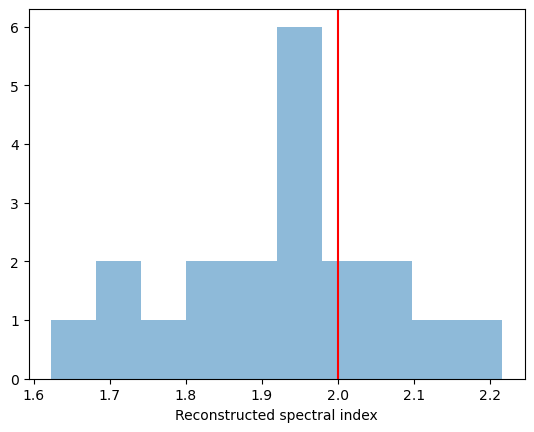

In [30]:
fig, ax = plt.subplots()
index = np.array([_["index"] for _ in results])
ax.hist(index, bins=10, alpha=0.5)
ax.axvline(x=model_simu.parameters["index"].value, color="red")
ax.set_xlabel("Reconstructed spectral index")
print(f"index: {index.mean()} += {index.std()}")
plt.show()

In [31]:
fitted_params = Table(results).to_pandas()

In [32]:
mean = fitted_params.mean()
uncertainty = fitted_params.std()

In [33]:
for name in ['amplitude', 'index', 'lambda_']:
    print(f"{name} :\t {mean[name]:.2e} -+ {uncertainty[name]:.2e}")

amplitude :	 1.06e-12 -+ 1.31e-13
index :	 1.93e+00 -+ 1.48e-01
lambda_ :	 1.37e-01 -+ 6.17e-02


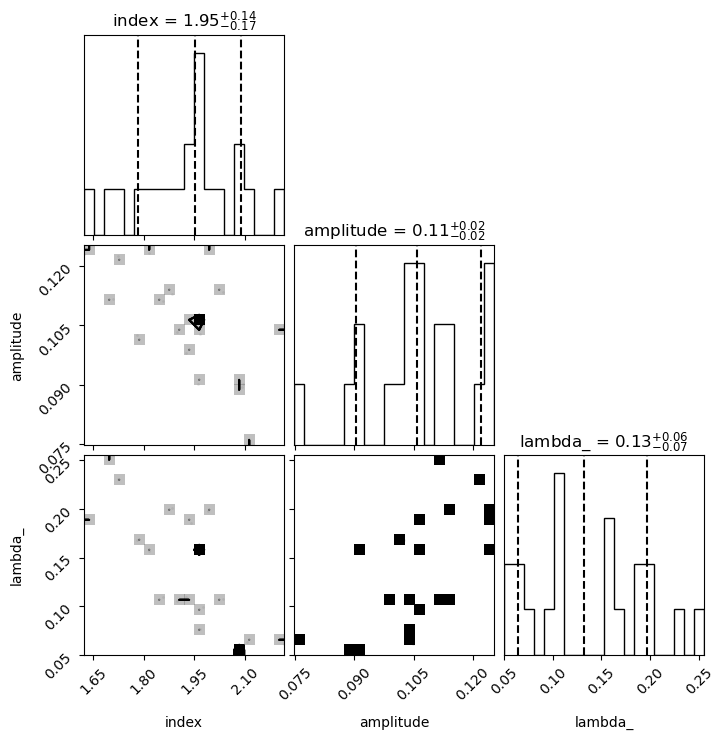

In [34]:
fitted_params['amplitude'] *= 1e11

figure = corner.corner(fitted_params,quantiles=[0.16, 0.5, 0.84],
              show_titles=True, title_kwargs={"fontsize": 12})

<a id='step8'></a>
🔝 [Back to Top](#intro)<br>
## Step 8: Computing the Flux Points
We can now compute some flux points using the `~gammapy.estimators.FluxPointsEstimator`.

Besides the list of datasets to use, we must provide it the energy intervals on which to compute flux points as well as the model component name.

In [35]:
#Compute flux points
datasets.models = [model]

# fit_joint = Fit(backend='sherpa')
fit_joint = Fit()
result_joint = fit_joint.run(datasets=datasets)
print(result_joint)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 61
	total stat : 230.02

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [36]:
energy_edges = MapAxis.from_energy_bounds(
    e_edges_min,
    e_edges_max, 
    nbin=12).edges
print(energy_edges)

[1.00000000e-01 1.77827941e-01 3.16227766e-01 5.62341325e-01
 1.00000000e+00 1.77827941e+00 3.16227766e+00 5.62341325e+00
 1.00000000e+01 1.77827941e+01 3.16227766e+01 5.62341325e+01
 1.00000000e+02] TeV


In [37]:
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, 
    source=model.name, 
    selection_optional="all"
)
flux_points = fpe.run(datasets=datasets)

In [38]:
dataset = FluxPointsDataset(
    data=flux_points, 
    models=model, 
    name=model.name
)

In [39]:
print(dataset)

FluxPointsDataset
-----------------

  Name                            : source 

  Number of total flux points     : 12 
  Number of fit bins              : 10 

  Fit statistic type              : chi2
  Fit statistic value (-2 log(L)) : 4.58

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index                         :      1.959   +/-    0.03             
      amplitude                     :   1.03e-12   +/- 3.9e-14 1 / (TeV s cm2)
      reference             (frozen):      1.000       TeV         
      lambda_                       :      0.116   +/-    0.02 1 / TeV     
      alpha                 (frozen):      1.000                   
  
  


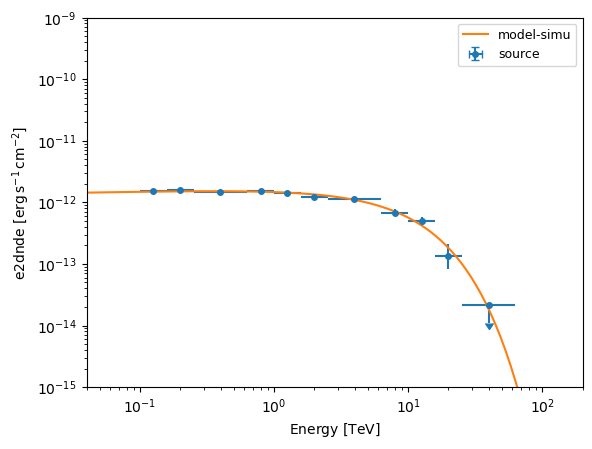

In [40]:
ax = plt.subplot()
ax.yaxis.set_units(u.Unit("erg cm-2 s-1"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

dataset.data.plot(label=dataset.name, **kwargs)
energy_bounds = [4e-2, 2e2] * u.TeV
model.spectral_model.plot(energy_bounds,label="model-simu",**kwargs)

ax.set_ylim(1e-15, 1e-9)
ax.set_xlim(energy_bounds)
ax.legend(fontsize=9, bbox_to_anchor=(1, 1))
plt.show()